# Keras TFboy 3D ConvNet


计划步骤

### 预处理

按照 full preprocessing.ipynb 的 resample 方法来做, 

每组 scan 按照 `1mm * 1mm * 1mm`, `1.5mm * 1.5mm * 1.5mm`, `3mm * 3mm * 3mm` 采样

先试试数据最小的 3mm


### Conv Net

按照 first pass through.ipynb 的方式来

但不直接使用 tf, 改用 keras 

网络参数抄 first pass through.ipynb 的

```
X - Conv3D(3,3,3, 32) - RELU - Pool3D
  - Conv3D(3,3,3, 64) - RELU - Pool3D
  - Flatten
  - FC(54080,1024) - RELU - Dropout
  - FC(1024, 2) - Softmax?
```

最后也许不应该用 softmax



In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
import random
def random_hue(s=100, l=80):
  return 'hsl({}, {}%, {}%)'.format(random.randint(0, 360), s, l)

color1 = random_hue(s=20, l=95)
color2 = random_hue(s=40, l=80)
css = '''
<style>
div.cell {{background-color: {color1};}}
div.running {{background-color: {color2};}}
div.running.selected {{background-color: {color2};}}
</style>'''.format(color1=color1, color2=color2)

display(HTML(css))

In [10]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [6]:
# Some constants 
INPUT_FOLDER = 'ct_sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

print(patients)

['00cba091fa4ad62cc3200a657aeb957e', '0a099f2549429d29b32f349e95fb2244', '0a0c32c9e08cc2ea76a71649de56be6d', '0a38e7597ca26f9374f8ea2770ba870d', '0acbebb8d463b4b9ca88cf38431aac69', '0b20184e0cd497028bdd155d9fb42dc9', '0bd0e3056cbf23a1cb7f0f0b18446068', '0c0de3749d4fe175b7a5098b060982a1', '0c37613214faddf8701ca41e6d43f56e', '0c59313f52304e25d5a7dcf9877633b1', '0c60f4b87afcb3e2dfa65abbbf3ef2f9', '0c98fcb55e3f36d0c2b6507f62f4c5f1', '0c9d8314f9c69840e25febabb1229fa4', '0ca943d821204ceb089510f836a367fd', '0d06d764d3c07572074d468b4cff954f', '0d19f1c627df49eb223771c28548350e', '0d2fcf787026fece4e57be167d079383', '0d941a3ad6c889ac451caf89c46cb92a', '0ddeb08e9c97227853422bd71a2a695e', '0de72529c30fe642bc60dcb75c87f6bd']


In [8]:
# 常用函数



# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # value * slope + intercept 之后才是 HU 值
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)
  


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # 需要保存计算后的 spacing, 由于 round 原因, 与提供的 spacing 将有微小的差异
    # 单位 毫米
    # 那么resample的方法应该非常重要, 
    # 需要研究 `scipy.ndimage.interpolation.zoom(image, real_resize_factor)` 有没有其他可能的处理方法
    # 重采样非常慢, [0.3,0.3,0.3] 就受不了了
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing


  
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

    
    
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

      
      
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image





def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image
  
  

def zero_center(image):
    PIXEL_MEAN = 0.25
    image = image - PIXEL_MEAN
    return image

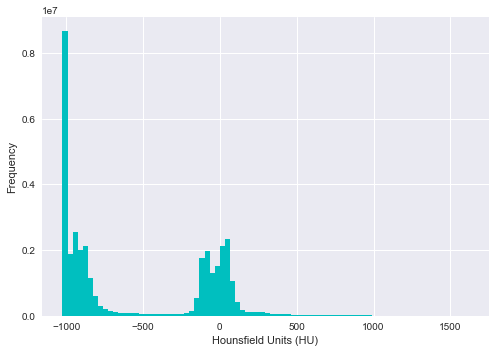

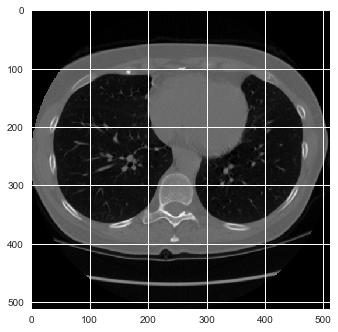

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (223, 204, 204)
[ 1.50224215  1.49999937  1.49999937]


In [11]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()


# pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])
# 1mm*1mm*1mm 之后在 plot_3d 时太慢了, 改粗略些
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1.5, 1.5, 1.5])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

print(spacing)

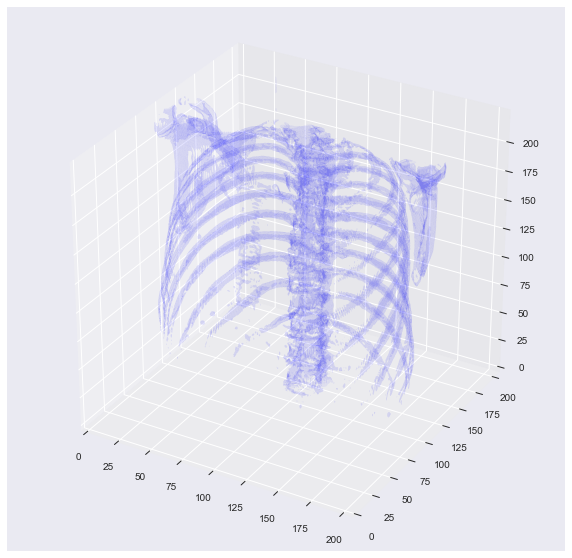

segmented_lungs
segmented_lungs_fill
segmented_lungs_fill - segmented_lungs


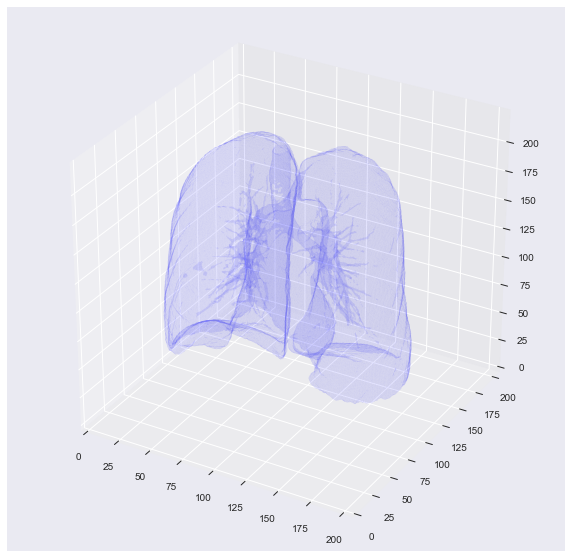

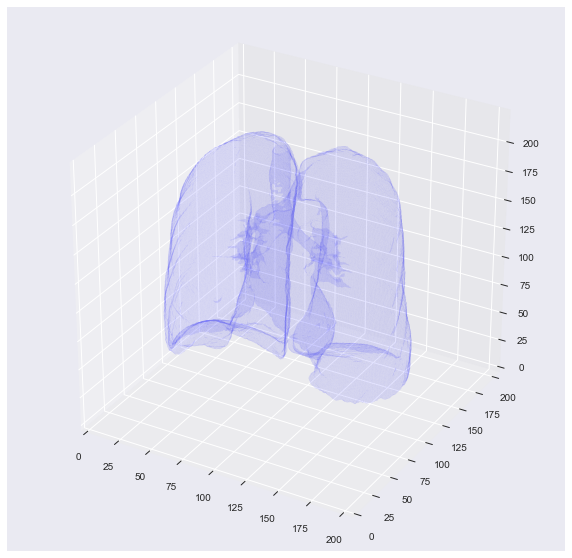

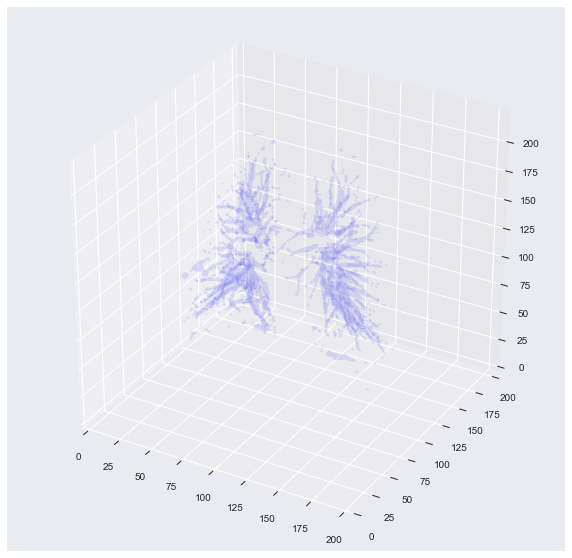

In [12]:
plot_3d(pix_resampled, 400)

segmented_lungs = segment_lung_mask(pix_resampled, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, fill_lung_structures=True)


print("segmented_lungs")
print("segmented_lungs_fill")
print("segmented_lungs_fill - segmented_lungs")

plot_3d(segmented_lungs, 0)
plot_3d(segmented_lungs_fill, 0)
plot_3d(segmented_lungs_fill - segmented_lungs, 0)